# Import libraries

In [13]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import nltk
from textblob import TextBlob
from nltk.tokenize import word_tokenize
import numpy as np
import pickle

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

warnings.filterwarnings("ignore")
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /Users/linainsaf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/linainsaf/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/linainsaf/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Import data and few analysis

In [16]:
# Import dataset
data = pd.read_csv("data/Hindi_english_dataset.csv")

In [17]:
# print length of dataset and data
print(len(data))
data.head()

6357


,Text,Sentiment
0,Jab tak Kohli captain se aur Shastri coach se ...,0
1,Really I agree to you viru paaji ab Ravi shas...,1
2,aur ke players ki mentality aur techniques s...,1
3,Kewal Ravi shashtri ko bhagao Indian team phir...,0
4,Jab RohitSharma Run Bana Raha Tha To Ye Godi ...,0


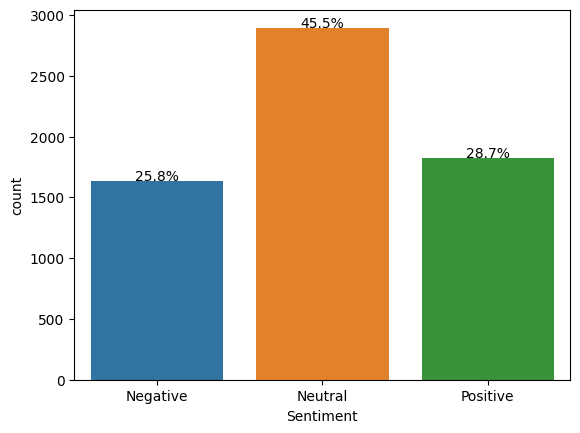

In [18]:
# Plot distribution of the classes
ax = sns.countplot(x=data["Sentiment"].map({0:"Negative" ,1:"Neutral", 2:"Positive"}))

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/ float(len(data)))
    x = p.get_x() + p.get_width()/2
    y = p.get_height()+.05
    ax.annotate(percentage, (x, y), ha='center')
plt.show()

# Data preprocessing

In [19]:
# Preprocessing function
def preprocess(text, vocabulary):

    # Lower text and remove special characters 
    output = text.lower()
    output = output.replace('[^\w\s]', '')

    # Tokenization
    output_tok = word_tokenize(output)

    # Lemmatization
    output_tok =  [vocabulary[tok] if tok in vocabulary else tok for tok in output_tok]

    # Join
    out = " ".join(output_tok)

    return output

In [20]:
# Import stopword list 
stopwords = list(pd.read_csv("data/Stopwords.csv")['Vocabulary'])

# Import lemmatization vocabulary
vocabulary = pd.read_csv("data/Generalised_spelling.csv").drop_duplicates(subset=["Vocabulary"], keep='first')
voc = dict(zip(vocabulary['Vocabulary'].str.lower(), vocabulary['Generalised Spelling']. str.lower()))

In [21]:
# Preprocess text
data['preprocessed']  = [preprocess(text, voc) for text in data["Text"] ]
data.head(2)

,Text,Sentiment,preprocessed
0,Jab tak Kohli captain se aur Shastri coach se ...,0,jab tak kohli captain se aur shastri coach se ...
1,Really I agree to you viru paaji ab Ravi shas...,1,really i agree to you viru paaji ab ravi shas...


In [22]:
# To obtain words that decide the polarity of our sentences.
def lem(message):
    words = TextBlob(message).words
    return [word.lemma for word in words]

# Models

## Ensemble based approach

#### Train-Test Split

In [100]:
X_train, X_test, Y_train, Y_test = train_test_split(data['preprocessed'], data['Sentiment'], test_size=0.15, random_state=123)

#### TF-IDF vectorization

In [101]:
vectorizer = TfidfVectorizer(analyzer=lem, ngram_range = (1,3), stop_words = stopwords)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [110]:
pickle.dump(vectorizer, open("tokenizers/ensemble_vectorizer.pkl", 'wb'))

Model building

In [102]:
MNB = MultinomialNB()                                                                                       # MNB model creation
SVM= SVC(probability=True)                                                                              # SVM model creation
SGD= SGDClassifier(max_iter=1000)                                                                 # SGD model creation
LR = LogisticRegression(multi_class='multinomial', solver='newton-cg')        # LR model creation

# Ensambling the models  with a soft voting classifier 
clf = VotingClassifier(estimators=[('SVC', SVM), ('MNB', MNB),
                                                         ('LR', LR), ('SGD', SGD)], voting='soft')

params = {'SVC__C': [1, 10], 'SVC__gamma': [0.001], 'SVC__kernel': ['rbf'],
          'MNB__alpha': [1e-2],
          'LR__penalty' : ['l2'],                                # Parameters to tune
          'SGD__loss': ["log", "modified_huber"],"SGD__alpha" : [0.01],
          'SGD__penalty' : ["l1"]}

""" 
# More parameters to explore using gridsearch 
params = {'SVC__C': [1, 10, 100], 'SVC__gamma': [0.001], 'SVC__kernel': ['rbf', 'linear'],
          'MNB__alpha': [1, 1e-1, 1e-2],
          'LR__penalty' : ['l2'],'LR__C' : np.logspace(-4, 4, 4),
          'SGD__loss': ["log", "modified_huber"],"SGD__alpha" : [0.001, 0.01],
          'SGD__penalty' : ["l2", "l1"]}
"""
#  K-fold cross validation for better training
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X_train, Y_train)

# GridSearch on the Voting classifier
model1 = GridSearchCV(clf, params, refit=True, n_jobs=-1, scoring='accuracy', cv=skf)

#### Model training

In [103]:
model1.fit(X_train, Y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=VotingClassifier(estimators=[('SVC',
                                                     SVC(probability=True)),
                                                    ('MNB', MultinomialNB()),
                                                    ('LR',
                                                     LogisticRegression(multi_class='multinomial',
                                                                        solver='newton-cg')),
                                                    ('SGD', SGDClassifier())],
                                        voting='soft'),
             n_jobs=-1,
             param_grid={'LR__penalty': ['l2'], 'MNB__alpha': [0.01],
                         'SGD__alpha': [0.01],
                         'SGD__loss': ['log', 'modified_huber'],
                         'SGD__penalty': ['l1'], 'SVC__C': [1, 10],
                         'SVC__gamma': [0.001

#### Model evaluation

In [104]:
y_pred = model1.predict(X_test)
accuracy_score(Y_test, y_pred)

0.6163522012578616

In [107]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.54      0.55       256
           1       0.60      0.72      0.66       438
           2       0.70      0.52      0.60       260

    accuracy                           0.62       954
   macro avg       0.63      0.59      0.60       954
weighted avg       0.62      0.62      0.61       954



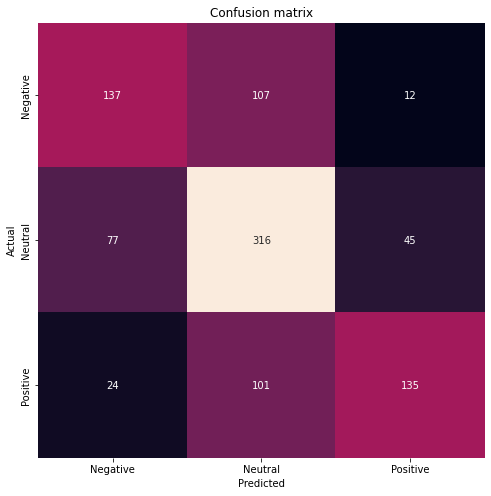

In [108]:
classnames = ['Negative', 'Neutral', 'Positive']
plt.figure(figsize=(8,8))
plt.title('Confusion matrix')
sns.heatmap(confusion_matrix(Y_test, y_pred), cbar=False, xticklabels=classnames, yticklabels=classnames, fmt='d', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [111]:
pickle.dump(model1, open("models/ensemble_model.pkl", 'wb'))

## Bidirectional LSTM based approach

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Bidirectional, Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

#### Data preprocessing and tokenization

In [127]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5000

# Max number of words in each 
MAX_SEQUENCE_LENGTH = 80

# Embedding layer dimension
EMBEDDING_DIM = 32

# Create the tokenization and fit on our data
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['Text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 14437 unique tokens.


In [153]:
pickle.dump(tokenizer, open("tokenizers/tokenizer_lstm.pkl", 'wb'))

In [132]:
# transform our data padded tensors 
X = tokenizer.texts_to_sequences(data['preprocessed'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (6357, 120)


In [133]:
# transform labels to tensors
Y = pd.get_dummies(data['Sentiment']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (6357, 3)


#### Train-Test Split

In [139]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 123)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(5721, 120) (5721, 3)
(636, 120) (636, 3)


#### Model building

In [140]:
# helper function for stopping training when the accuracy decreases
callback = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

In [141]:
model2 = Sequential()
model2.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model2.add(SpatialDropout1D(0.2))

model2.add(Bidirectional(LSTM(128,  dropout=0.2, recurrent_dropout=0.2,return_sequences=True)))
model2.add(Bidirectional(LSTM(64,  dropout=0.2, recurrent_dropout=0.2,return_sequences=True)))
model2.add(Bidirectional(LSTM(32,  dropout=0.2, recurrent_dropout=0.2)))

model2.add(Dense(16, activation='relu'))
model2.add(Dense(3, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 42)           252000    
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 120, 42)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_9 (Bidirectio  (None, 120, 256)         175104    
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 120, 128)         164352    
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 64)               41216     
 onal)                                                

#### Model training

In [146]:
epochs = 10
batch_size = 64
history = model2.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1, callbacks=[callback])

Epoch 1/10
81/81 [==============================] - 100s 1s/step - loss: 1.0554 - accuracy: 0.4520 - val_loss: 1.0162 - val_accuracy: 0.5044
Epoch 2/10
81/81 [==============================] - 82s 1s/step - loss: 0.9494 - accuracy: 0.5305 - val_loss: 0.9902 - val_accuracy: 0.4660
Epoch 3/10
81/81 [==============================] - 82s 1s/step - loss: 0.7615 - accuracy: 0.6638 - val_loss: 0.9775 - val_accuracy: 0.5777
Epoch 4/10
81/81 [==============================] - 80s 992ms/step - loss: 0.5906 - accuracy: 0.7617 - val_loss: 1.0203 - val_accuracy: 0.5742
Epoch 5/10
81/81 [==============================] - 82s 1s/step - loss: 0.4405 - accuracy: 0.8372 - val_loss: 1.1047 - val_accuracy: 0.5846
Epoch 6/10
81/81 [==============================] - 82s 1s/step - loss: 0.3478 - accuracy: 0.8800 - val_loss: 1.2148 - val_accuracy: 0.5899
Epoch 7/10
81/81 [==============================] - 79s 981ms/step - loss: 0.3008 - accuracy: 0.8955 - val_loss: 1.2055 - val_accuracy: 0.5951
Epoch 8/10
81

#### Model evaluation

In [144]:
accr = model2.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f} %'.format(accr[0],accr[1]*100))

20/20 [==============================] - 4s 204ms/step - loss: 1.7724 - accuracy: 0.5818
Test set
  Loss: 1.772
  Accuracy: 58.176 %


In [147]:
y_pred = model2.predict(X_test, verbose=0)

In [149]:
print(classification_report(Y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.55      0.51      0.53       177
           1       0.61      0.62      0.61       289
           2       0.52      0.54      0.53       170

    accuracy                           0.57       636
   macro avg       0.56      0.56      0.56       636
weighted avg       0.57      0.57      0.57       636



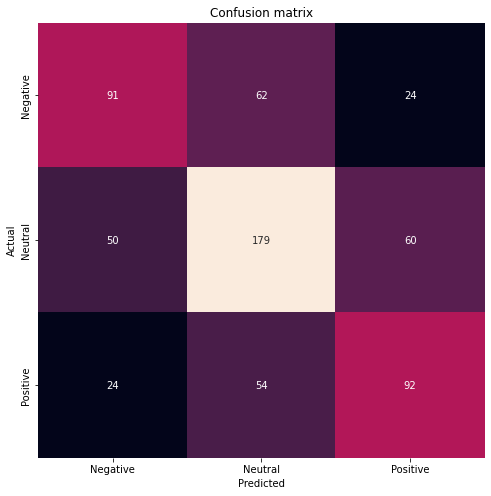

In [151]:
classnames = ['Negative', 'Neutral', 'Positive']
plt.figure(figsize=(8,8))
plt.title('Confusion matrix')
sns.heatmap(confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1)), cbar=False, xticklabels=classnames, yticklabels=classnames, fmt='d', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [154]:
pickle.dump(model2, open("models/bilstm_model.pkl", 'wb'))